In [1]:
import numpy as np

import jax
import jax.numpy as jnp

# -------------- helper libraries -------------- #
import sys
import os
import time
import pickle

import matplotlib.pyplot as plt
import pandas as pd
import importlib
import itertools

path_ = os.path.abspath(os.path.join('..', '00_utils'))

if path_ not in sys.path:
    sys.path.append(path_)
    
path_ = os.path.abspath(os.path.join('..', '00_models'))

if path_ not in sys.path:
    sys.path.append(path_)

path_ = os.path.abspath(os.path.join('..', '00_utils_training'))

if path_ not in sys.path:
    sys.path.append(path_)

import run_train_toy
import logging
logging.basicConfig(level=logging.ERROR, filename='error_log.txt')

In [2]:
def load_trainer(type_, spacing_type="uniform"):
    importlib.reload(run_train_toy)
    TrainerToy = run_train_toy.TrainerToy
    
    data_params_ho = {
        'N': 200,
        'noise_level': 0.2,
        'ode_type': "harmonic_oscillator",
        'data_param': {"omega_squared": 2},
        'start_time': 0,
        'end_time': 10,
        'spacing_type': spacing_type,
        'initial_state': np.array([0.0, 1.0])
    }

    data_params_vdp = {
        'N': 200,
        'noise_level': 0.1,
        'ode_type': "van_der_pol",
        'data_param': {"mu": 1, "omega": 1},
        'start_time': 0,
        'end_time': 15,
        'spacing_type': spacing_type,
        'initial_state': np.array([0.0, 1.0])
    }

    data_params_do = {
        'N': 200,
        'noise_level': 0.1,
        'ode_type': "damped_oscillation",
        'data_param': {"damping_factor": 0.1, "omega_squared": 1},
        'start_time': 0,
        'end_time': 10,
        'spacing_type': spacing_type,
        'initial_state': np.array([0.0, 1.0])
    }

    if type_ == "ho":
        p_ = data_params_ho
    elif type_ == "vdp":
        p_ = data_params_vdp
    elif type_ == "do":
        p_ = data_params_do
    else:
        raise ValueError(f"Invalid type {type_}")

    trainer = TrainerToy(p_, model_type="jax_diffrax")
    trainer.prepare_inputs()
    return trainer

In [3]:
reg_list = [1e-5, 1e-4, 1e-3]
max_iter_li = [500, 1000, 1500]

param_combinations = list(itertools.product(reg_list, max_iter_li))

for c in param_combinations:
    print(str(c))
    print("reg:", c[0], "max_iter:", c[1])

(1e-05, 500)
reg: 1e-05 max_iter: 500
(1e-05, 1000)
reg: 1e-05 max_iter: 1000
(1e-05, 1500)
reg: 1e-05 max_iter: 1500
(0.0001, 500)
reg: 0.0001 max_iter: 500
(0.0001, 1000)
reg: 0.0001 max_iter: 1000
(0.0001, 1500)
reg: 0.0001 max_iter: 1500
(0.001, 500)
reg: 0.001 max_iter: 500
(0.001, 1000)
reg: 0.001 max_iter: 1000
(0.001, 1500)
reg: 0.001 max_iter: 1500


In [85]:
TRAINER = load_trainer("ho")
RESULTS = {}
AVERAGED = False

optimization_type = 'network_size'

params_model = {
    'layer_widths': [2, 64, 2],
    'penalty_lambda_reg': 1e-5,
    'time_invariant': True,
    'learning_rate': 1e-3,
    'max_iter': 500,
    'pretrain': [0.2, 1],
    'verbose': False,
    'rtol': 1e-3,
    'atol': 1e-6,
    "log": False
}

if optimization_type == 'network_size':
  lw = [[2, 16, 2], [2, 32, 2], [2, 16, 16, 2], [2, 32, 32, 2]]
  lw_list = [[2, 16, 2], [2, 32, 2], [2, 64, 2], [2, 128, 2]]
  reg_list = [1e-5, 1e-4, 1e-3]
  max_iter_li = [500, 1000, 1500]
  param_combinations = list(itertools.product(lw, reg_list, max_iter_li))
elif optimization_type == 'tolerance':
  rtol = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
  atol = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
  param_combinations = list(itertools.product(rtol, atol))
elif optimization_type == 'none':
  param_combinations = [0]

  

total_iter = len(param_combinations)
i = 1

for param_comb in param_combinations:
    if optimization_type == 'network_size':
      lw = param_comb[0]
      params_model['layer_widths'] = lw
      params_model['penalty_lambda_reg'] = param_comb[1]
      params_model['max_iter'] = param_comb[2]
    elif optimization_type == 'tolerance':
      params_model['rtol'] = param_comb[0]
      params_model['atol'] = param_comb[1]
    else:
      if optimization_type != 'none':
        raise ValueError("Invalid optimization type")
      else:
        params_model['log'] = True
    
    print(params_model['log'])
    if not AVERAGED:
      try:
        TRAINER.train(params_model)
      except Exception as e:
        print("Failed to complete training: {}".format(e))
        logging.error("Failed to complete training: {}".format(e))
        continue
      
      result = TRAINER.extract_results()
      RESULTS[param_comb] = result
      
      print(RESULTS[param_comb]['mse_train'])
      print(RESULTS[param_comb]['mse_test'])
      
    if AVERAGED:
      mse_train = []
      mse_test = []
      time_elapsed = []
      for _ in range(5):
        try:
          TRAINER.train(params_model)
        except Exception as e:
          print("Failed to complete training: {}".format(e))
          logging.error("Failed to complete training: {}".format(e))
          continue
          
        result = TRAINER.extract_results()
        mse_train.append(result['mse_train'])
        mse_test.append(result['mse_test'])
        time_elapsed.append(result['time_elapsed'])
      
      if optimization_type == 'network_size' and len(params_model[0]) == 3:
        k = (param_comb[0][1], param_comb[1], param_comb[2])
        param_comb = k
        
      RESULTS[param_comb] = {
          'mse_train': np.mean(mse_train),
          'mse_test': np.mean(mse_test),
          'time_elapsed': np.mean(time_elapsed)
      }
      
      print(RESULTS[param_comb]['mse_train'])
      print(RESULTS[param_comb]['mse_test'])
    
    print("Iteration:", i, "/", total_iter)
    i+=1

False


TypeError: unhashable type: 'list'

In [80]:
losses = TRAINER.losses
c = RESULTS[0]['time_elapsed'][1]/len(losses[0])

In [81]:
# losses = np.concatenate(losses)
times = np.array([i*c for i in range(len(losses[1]))])

[]

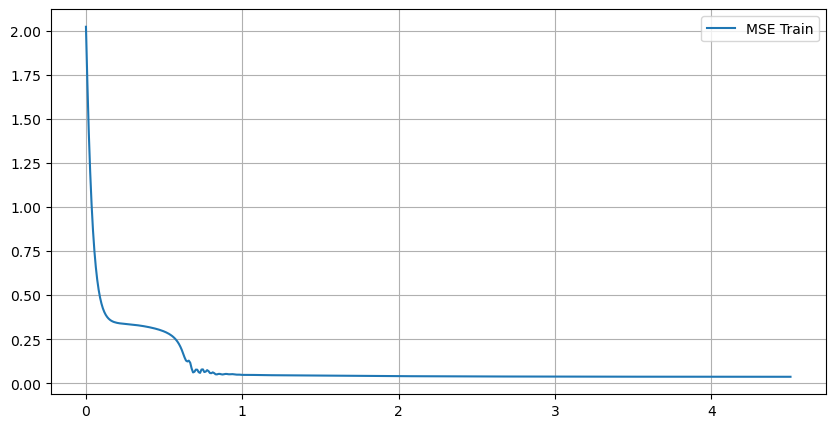

In [84]:
plt.figure(figsize=(10, 5))
plt.grid()
plt.plot([i*c for i in range(len(losses[1]))], losses[1], label='MSE Train')
plt.legend()
plt.plot()

In [23]:
RESULTS[(0.1, 0.001)].keys()

dict_keys(['time_elapsed', 'odeint_pred', 'odeint_pred_test', 'mse_train', 'mse_test'])

In [20]:
reload = True
if reload:
    formatted_time = time.strftime('%Y-%m-%d_%H-%M-%S')
    filename = f'results/diffrax_{formatted_time}_tolerances.pkl'
    with open(filename, 'wb') as file:
        pickle.dump(RESULTS, file)